# Multi-modal RAG
Many documents contain a mixture of content types, including text and images.

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:`
* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis

`Option 2:`
* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text
* Pass text chunks to an LLM for answer synthesis

`Option 3`
* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image
* Pass raw images and text chunks to a multimodal LLM for answer synthesis

---
This cookbook highlights `Option 3`.
* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) with [Chroma](https://www.trychroma.com/) to store raw text and images along with their summaries for retrieval.
* We will use GPT-4V for both image summarization (for retrieval) as well as final answer synthesis from join review of images and texts (or tables).
---
A separate cookbook highlights `Option 1` [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/multi_modal_RAG_chroma.ipynb).

And `Option 2` is appropriate for cases when a multi-modal LLM cannot be used for answer synthesis (e.g., cost, etc.)


# 1.0 Packages
In addition to the below pip packages, you will also need poppler ([installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html)) and tesseract ([installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html)) in your system.

In [1]:
!apt-get install poppler-utils tesseract-ocr libmagic-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libmagic-dev poppler-utils tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 5,107 kB of archives.
After this operation, 16.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libmagic-dev amd64 1:5.41-3ubuntu0.1 [105 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 te

In [2]:
! pip install -Uq langchain-openai langchain-chroma langchain-experimental # (newest versions required for multi-modal)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.2 MB/s eta 0:00:00

In [3]:
! pip install -Uq "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 523.4/523.4 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import os
from google.colab import userdata

OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")
LANGCHAIN_API_KEY = userdata.get("LANGCHAIN_API_KEY")

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"

# 2.0 Partition PDF into Text, Tables and Images
Let's look at a [popular blog](https://cloudedjudgement.substack.com/p/clouded-judgement-111023) by Jamin Ball.

This is a great use-case because much of the information is captured in images (of tables or charts).

We use `Unstructured` to partition it (see [blog post](https://blog.langchain.dev/semi-structured-multi-modal-rag/)).

In [5]:
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf

<font color='blue'>Experiment</font>

In [6]:
output_path = "/content/"
file_path = 'LlaVa.pdf'

# chunks = partition_pdf(
#     filename=file_path,
#     infer_table_structure=True,            # extract tables
#     strategy="hi_res",                     # mandatory to infer tables
#     extract_image_block_types=["Image", "Table"],   # Add 'Table' to list to extract image of tables
#     extract_image_block_to_payload=True,   # if true, will extract base64 for API usage
#     chunking_strategy="by_title",          # or 'basic'
#     max_characters=4000,                  # defaults to 500
#     new_after_n_chars=3800,
#     combine_text_under_n_chars=2000,       # defaults to 0
# )

In [ ]:
# chunks

In [ ]:
# len(chunks)

30

## 2.1 Experiment: Text

In [ ]:
# Extracting Text
# text = []
# text = [chunk.text for chunk in chunks if isinstance(chunk, Text)]
# text

['3\n\n2023\n\n2\n\n0\n\n2\n\ng u A 2 ] L C . s c [ 7 v 2 6 7 3 0 . 6 0 7\n\n1\n\n:\n\nv\n\narXiv\n\ni\n\nX\n\nr\n\na\n\nProvided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.\n\nAttention Is All You Need\n\nAshish Vaswani∗\n\nGoogle Brain\n\navaswani@google.com\n\nNoam Shazeer∗ Google Brain noam@google.com\n\nNiki Parmar∗ Google Research nikip@google.com\n\nJakob Uszkoreit∗\n\nGoogle Research usz@google.com\n\nLlion Jones∗\n\nGoogle Research llion@google.com\n\nAidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu\n\nŁukasz Kaiser∗ Google Brain lukaszkaiser@google.com\n\nIllia Polosukhin∗ ‡\n\nillia.polosukhin@gmail.com\n\nAbstract\n\nThe dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention 

## 2.2 Experiment: Tables

In [ ]:
# Extracting Tables (Including Nested in Composite Element)
# tables = []

# for chunk in chunks:
#   if isinstance(chunk, Table):
#     tables.append(chunk.text)
#   elif isinstance(chunk, CompositeElement):
#     chunk_els = chunk.metadata.orig_elements
#     for el in chunk_els:
#       if "Table" in str(type(el)):
#         tables.append(el.metadata.text_as_html) # Change to text_as_html

# tables

['<table><thead><tr><th>Layer Type</th><th>Complexity per Layer</th><th>Sequential Operations</th><th>Maximum Path Length</th></tr></thead><tbody><tr><td>Self-Attention</td><td>O(n? - d)</td><td>O(1)</td><td>O(1)</td></tr><tr><td>Recurrent</td><td>O(n - d?)</td><td>O(n)</td><td>O(n)</td></tr><tr><td>Convolutional</td><td>O(k-n-d?)</td><td>O(1)</td><td>O(logx(n))</td></tr><tr><td>Self-Attention (restricted)</td><td>O(r-n-d)</td><td>ol)</td><td>O(n/r)</td></tr></tbody></table>',
 '<table><thead><tr><th>Model</th><th>EN-DE</th><th>BLEU EN-FR</th><th>Training EN-DE</th><th>Cost (FLOPs) EN-FR</th></tr></thead><tbody><tr><td colspan="5">ByteNet [18] 23.75</td></tr><tr><td>Deep-Att + PosUnk</td><td></td><td>39.2</td><td></td><td>1.0 - 107°</td></tr><tr><td>GNMT + RL 8]</td><td>24.6</td><td>39.92</td><td>2.3-10!9</td><td>1.4. 1070</td></tr><tr><td>ConvS28S [9]</td><td>25.16</td><td>40.46</td><td>9.6-10\'%</td><td>1.5-1070</td></tr><tr><td>MoE</td><td>26.03</td><td>40.56</td><td>2.0-10\'9</td><

## 2.3 Experiment: Images

In [ ]:
# images_b64 = []
# for chunk in chunks:
#     if "CompositeElement" in str(type(chunk)):
#         chunk_els = chunk.metadata.orig_elements
#         for el in chunk_els:
#             if "Image" in str(type(el)):
#                 images_b64.append(el.metadata.image_base64)
# images_b64

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAOAAmADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK5OTxVqWp6pdWPhjSI75LSQw3N/d3PkW6yjrGpCszsO

## 2.4 Function: extract_pdf_element()

In [7]:
# Extract elements from PDF
def extract_pdf_elements(path, fname):
  """
  Extract images, tables, and chunk text from a PDF file
  path: File path, which is used to dump images (.jpg)
  fname: File name
  """
  return partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables
    extract_image_block_types=["Image", "Table"],   # Add 'Table' to list to extract image of tables
    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage
    chunking_strategy="by_title",          # or 'basic'
    max_characters=4000,                   # defaults to 500
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,       # defaults to 0
)

In [9]:
chunks = extract_pdf_elements(output_path, file_path)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

## 2.5 Function: extract_pdf_content()

In [10]:
from unstructured.documents.elements import Text, Table, CompositeElement, Image
import base64

def extract_pdf_content(chunks):
    """
    Extracts text, tables, and images from processed chunks using the 'unstructured' library.

    Parameters:
        chunks (list): Processed output from partition_pdf().

    Returns:
        dict: A dictionary containing extracted text, tables (HTML), and images (Base64).
    """
    extracted_data = {
        "text": [],
        "tables": [],
        "images_base64": []
    }

    # Extract Text
    extracted_data["text"] = [chunk.text for chunk in chunks if isinstance(chunk, Text)]

    # Extract Tables (Including Nested in CompositeElement)
    for chunk in chunks:
        if isinstance(chunk, Table):
            extracted_data["tables"].append(chunk.metadata.text_as_html)  # Extract table as HTML
        elif isinstance(chunk, CompositeElement):
            chunk_elements = chunk.metadata.orig_elements
            for el in chunk_elements:
                if "Table" in str(type(el)):
                    extracted_data["tables"].append(el.metadata.text_as_html)

    # Extract Images (Base64 and Save)
    image_counter = 1
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    extracted_data["images_base64"].append(el.metadata.image_base64)

    return extracted_data

In [11]:
extracted_info = extract_pdf_content(chunks)

In [12]:
# Display results (text)
print("Extracted Text:\n", "\n".join(extracted_info["text"]))

Extracted Text:
 3

2023

2

0

2 c e D 1 1 ] V C . s c [ 2 v 5 8 4 8 0 . 4 0 3 2 :

v

arXiv

i

X

r

a

Visual Instruction Tuning

Haotian Liu1∗, Chunyuan Li2∗, Qingyang Wu3, Yong Jae Lee1

1University of Wisconsin–Madison 2Microsoft Research 3Columbia University https://llava-vl.github.io

Abstract

Instruction tuning large language models (LLMs) using machine-generated instruction-following data has been shown to improve zero-shot capabilities on new tasks, but the idea is less explored in the multimodal field. We present the first attempt to use language-only GPT-4 to generate multimodal language-image instruction-following data. By instruction tuning on such generated data, we in- troduce LLaVA: Large Language and Vision Assistant, an end-to-end trained large multimodal model that connects a vision encoder and an LLM for general- purpose visual and language understanding. To facilitate future research on visual instruction following, we construct two evaluation benchmarks with d

In [13]:
# Display the first chunk of text
print("First Chunk of Text:\n", extracted_info["text"][0])

First Chunk of Text:
 3

2023

2

0

2 c e D 1 1 ] V C . s c [ 2 v 5 8 4 8 0 . 4 0 3 2 :

v

arXiv

i

X

r

a

Visual Instruction Tuning

Haotian Liu1∗, Chunyuan Li2∗, Qingyang Wu3, Yong Jae Lee1

1University of Wisconsin–Madison 2Microsoft Research 3Columbia University https://llava-vl.github.io

Abstract

Instruction tuning large language models (LLMs) using machine-generated instruction-following data has been shown to improve zero-shot capabilities on new tasks, but the idea is less explored in the multimodal field. We present the first attempt to use language-only GPT-4 to generate multimodal language-image instruction-following data. By instruction tuning on such generated data, we in- troduce LLaVA: Large Language and Vision Assistant, an end-to-end trained large multimodal model that connects a vision encoder and an LLM for general- purpose visual and language understanding. To facilitate future research on visual instruction following, we construct two evaluation benchmarks w

In [14]:
# Display results (table)
print("\nExtracted Tables (HTML):\n", extracted_info["tables"])
print("\nNumber of Extracted Tables (HTML):", len(extracted_info["tables"]))


Extracted Tables (HTML):
 ['<table><thead><tr><th>|</th><th>Conversation</th><th>Detail</th><th>description</th><th>Complex reasoning</th><th>All</th></tr></thead><tbody><tr><td>Full data Detail + Complex</td><td>83.1 81.5 1.6</td><td>75.3 73.3 (20)</td><td></td><td>96.5 90.8 (5.7)</td><td>85.1 81.9 (32)</td></tr><tr><td>Conv + 5% Detail + 10% Complex |</td><td>81.0 (21)</td><td>68.4 (7.1)</td><td></td><td>91.5 (50)</td><td>80.5 (4.4)</td></tr><tr><td>Conversation</td><td>76.5 (6.6)</td><td>59.8 (16.2)</td><td></td><td>84.9 C124)</td><td>73.8 113)</td></tr><tr><td>No Instruction Tuning</td><td>22.0 (61.1)</td><td>24.0 (51.3)</td><td></td><td>18.5 (78.0)</td><td>21.5 (63.6)</td></tr></tbody></table>', '<table><thead><tr><th></th><th>| Conversation</th><th>Detail description</th><th>Complex reasoning</th><th>All</th></tr></thead><tbody><tr><td>OpenFlamingo [5] |</td><td>19.3 + 0.5</td><td>19.0 + 0.5</td><td>19.1 +0.7</td><td>19.1 + 0.4</td></tr><tr><td>BLIP-2 [28]</td><td>54.64 1.4</td>

In [15]:
# Display the first table
extracted_info["tables"][0]

'<table><thead><tr><th>|</th><th>Conversation</th><th>Detail</th><th>description</th><th>Complex reasoning</th><th>All</th></tr></thead><tbody><tr><td>Full data Detail + Complex</td><td>83.1 81.5 1.6</td><td>75.3 73.3 (20)</td><td></td><td>96.5 90.8 (5.7)</td><td>85.1 81.9 (32)</td></tr><tr><td>Conv + 5% Detail + 10% Complex |</td><td>81.0 (21)</td><td>68.4 (7.1)</td><td></td><td>91.5 (50)</td><td>80.5 (4.4)</td></tr><tr><td>Conversation</td><td>76.5 (6.6)</td><td>59.8 (16.2)</td><td></td><td>84.9 C124)</td><td>73.8 113)</td></tr><tr><td>No Instruction Tuning</td><td>22.0 (61.1)</td><td>24.0 (51.3)</td><td></td><td>18.5 (78.0)</td><td>21.5 (63.6)</td></tr></tbody></table>'

In [16]:
# Display results (table)
print("\nExtracted Images:", extracted_info["images_base64"])
print("\nNumber of Extracted Images:", len(extracted_info["images_base64"]))


Extracted Images: ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACeAPsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDxuKa3jPMCnHcsc/oavC/s2iKGyicn+Mu+4fT5gKxN47ilEg/uH86VgNASwgHYpAPUCgLbt0kkRvpVJZeOMD64pwkc/wAePwoA0kieIZFxgnpgEZ/lVhUZiFV2eQjhVT0696x/NA+/IPwxThcwjO2

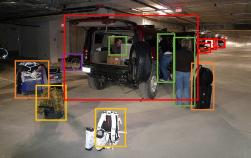

In [17]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(extracted_info["images_base64"][0])

# 3.0 Summarize the Data
Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

## 3.1 Text and Table Summaries
We will use GPT-4 to produce table and, optionall, text summaries.

Text summaries are advised if using large chunk sizes (e.g., as set above, we use 4k token chunks).

Summaries are used to retrieve raw tables and / or raw chunks of text.

In [18]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [21]:
def generate_text_summaries(texts, tables, summarize_texts=False):
  """
  Summarize text elements
  texts: List of str
  tables: List of str
  summarize_texts: Boolean to summarize texts
  """
  # Prompt
  prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
  These summaries will be embedded and used to retrieve the raw text or table elements. \
  Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element}"""
  prompt = ChatPromptTemplate.from_template(prompt_text)

  # Text summary chain
  model = ChatOpenAI(temperature=0, model="gpt-4o") # Choose gpt-4o, gpt-4 (tpm not enough)
  summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

  # Initialize empty summaries
  text_summaries = []
  table_summaries = []

  # Apply to text if texts are provided and summarization is requested
  if texts and summarize_texts:
    text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

  # Apply to table if tables are provided
  if tables:
    table_summaries = summarize_chain.batch(tables, {"max_concurrency": 3})

  return text_summaries, table_summaries

Experiment: Text and Table Summaries

In [22]:
# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(extracted_info["text"], extracted_info["tables"], summarize_texts=True)

In [24]:
# Returned text_summaries (List)
text_summaries[0]

'This document discusses the development of LLaVA (Large Language and Vision Assistant), a multimodal model that integrates a vision encoder with a large language model (LLM) for enhanced visual and language understanding. The study explores instruction tuning using machine-generated data from GPT-4 to improve zero-shot capabilities in multimodal tasks. LLaVA demonstrates strong performance in multimodal chat and achieves a high relative score compared to GPT-4 on a synthetic dataset. It also sets a new state-of-the-art accuracy of 92.53% when fine-tuned on Science QA. The research includes the creation of two evaluation benchmarks and makes the generated data, model, and code publicly accessible.'

In [25]:
# Returned table_summaries (List)
table_summaries[0]

'This table presents performance metrics across different configurations for a task involving conversation, detail, and complex reasoning. The configurations include "Full data Detail + Complex," "Conv + 5% Detail + 10% Complex," "Conversation," and "No Instruction Tuning." Each configuration is evaluated on metrics such as "Conversation," "Detail," "Complex reasoning," and "All." The "Full data Detail + Complex" configuration shows the highest performance across all metrics, with scores like 83.1 for Conversation and 96.5 for Complex reasoning. In contrast, "No Instruction Tuning" has the lowest scores, such as 22.0 for Conversation and 18.5 for Complex reasoning. The table highlights the impact of different data configurations on task performance.'

## 3.2 Image Summaries
We will use gpt-4-o-mini to produce the image summaries.

In [28]:
from openai import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser

def generate_image_summarize(img_base64):
    """
    Generate summaries for a list of base64-encoded images.

    Parameters:
        img_base64 (list): List of base64-encoded images.

    Returns:
        list: List of summaries for each image.
    """
    # Store image summaries
    image_summaries = []

    # Initialize OpenAI Chat Model
    chat = ChatOpenAI(model="gpt-4o-mini")

    # Define the prompt template
    prompt_template = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    for image in img_base64:
        # Construct dynamic messages for each image
        messages = [
            ("user", [
                {"type": "text", "text": prompt_template},
                {"type": "image_url", "image_url": f"data:image/jpeg;base64,{image}"},
            ])
        ]

        # Create ChatPromptTemplate dynamically
        prompt = ChatPromptTemplate.from_messages(messages)
        chain = prompt | chat | StrOutputParser()

        # Generate summary
        summary = chain.invoke({"image": image})
        image_summaries.append(summary)

    return image_summaries

In [30]:
# Generate image summaries
image_summaries = generate_image_summarize(extracted_info["images_base64"])

<ipython-input-28-24843c003cc2>:20: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  chat = ChatOpenAI(model="gpt-4o-mini")


In [31]:
# Returned images_summaries (List)
image_summaries[0]

'Image depicts a parking garage scene featuring an SUV with its rear open. Several individuals are seen loading luggage and bags into the vehicle. Various items, such as suitcases and gear bags, are scattered around the area, highlighted in colored boxes. The setting is dimly lit, emphasizing the indoor parking environment.'

## 3.3 Save as JSON for Backup

In [32]:
# Backup text_summaries and table_summaries for later experiment
import json

def save_summaries_to_json(text_summaries, table_summaries, image_summaries, filename="summaries_backup.json"):
    """
    Save text and table summaries to a JSON file.

    Parameters:
        text_summaries (list): List of text summaries.
        table_summaries (list): List of table summaries.
        image_summaries (list): List of image summaries.
        filename (str): Name of the backup file.
    """
    data = {
        "text_summaries": text_summaries,
        "table_summaries": table_summaries,
        "image_summaries": image_summaries
    }

    with open(filename, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

    print(f"✅ Backup saved: {filename}")

save_summaries_to_json(text_summaries, table_summaries, image_summaries)

✅ Backup saved: summaries_backup.json


# 4.0 Load Data and Summaries to Vector Store

## 4.1 Create the Vector Store

In [33]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [35]:
def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

In [36]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# Create retriever
retriever = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    extracted_info["text"],
    table_summaries,
    extracted_info["tables"],
    image_summaries,
    extracted_info["images_base64"]
)

## 4.2 Check the Retrieval

In [37]:
# Retrieve
docs = retriever.invoke(
    "Who are the authors of the paper?"
)

In [38]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

[38] Baolin Peng, Chunyuan Li, Pengcheng He, Michel Galley, and Jianfeng Gao. Instruction tuning with GPT-4. arXiv preprint arXiv:2304.03277, 2023. 1, 4

[39] Hieu Pham, Zihang Dai, Golnaz Ghiasi, Kenji Kawaguchi, Hanxiao Liu, Adams Wei Yu, Jiahui Yu, Yi-Ting Chen, Minh-Thang Luong, Yonghui Wu, et al. Combined scaling for open-vocabulary image classification. arXiv preprint arXiv: 2111.10050, 2021. 1

[40] Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal, Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, et al. Learning transferable visual models from natural language supervision. arXiv preprint arXiv:2103.00020, 2021. 1, 2, 4

[41] Colin Raffel, Noam Shazeer, Adam Roberts, Katherine Lee, Sharan Narang, Michael Matena, Yanqi Zhou, Wei Li, and Peter J Liu. Exploring the limits of transfer learning with a unified text-to-text transformer. The Journal of Machine Learning Research, 2020. 2

[42] Aditya Ramesh, Prafulla Dhariwal, Alex Nichol, 

# 5.0 Create RAG Pipeline

In [39]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode

In [52]:
def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            # Validate if `doc` is a base64 image
            base64.b64decode(doc)  # If this fails, it’s not a valid base64 image
            b64.append(doc)
        except Exception:
            text.append(doc)
    return {"images": b64, "texts": text}

In [53]:
def build_prompt(kwargs):
    """
    Build a prompt with text and base64-encoded image context.

    Parameters:
        kwargs (dict): Dictionary containing "context" and "question".

    Returns:
        ChatPromptTemplate: A structured prompt template.
    """
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    # Merge text elements into a single string
    context_text = "\n".join(docs_by_type["texts"]) if docs_by_type["texts"] else ""

    # Construct prompt with context (text, tables, images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and images.

    Context: {context_text}
    Question: {user_question}
    """

    # Initialize prompt content
    prompt_content = [{"type": "text", "text": prompt_template}]

    # Append images if present
    for image in docs_by_type["images"]:
        prompt_content.append(
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
        )

    # Return structured prompt
    return ChatPromptTemplate.from_messages([HumanMessage(content=prompt_content)])

In [54]:
chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

In [55]:
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [57]:
response = chain.invoke(
    "What is LLaVa?"
)
print(response)

LLaVA, or Large Language and Vision Assistant, is an end-to-end trained large multimodal model designed for general-purpose visual and language understanding. It connects a vision encoder with a large language model (LLM) and is built upon instruction tuning using machine-generated multimodal language-image instruction-following data from GPT-4. LLaVA aims to improve zero-shot capabilities on new tasks in the multimodal field, demonstrating impressive chat abilities, creative writing, and the capacity to follow user instructions while understanding visual content. The model has been evaluated against benchmarks and shown to achieve high accuracy, including a state-of-the-art score when fine-tuned on specific tasks.


In [59]:
def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

In [72]:
response = chain_with_sources.invoke(
    "What is instruction tuning?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text)
    # print("Page number: ", text.metadata.page_number) # Coz we extract text instead of CompositeElement
    # print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: Instruction tuning refers to the process of adjusting a language model (LLM) to follow natural language instructions and complete various real-world tasks. In the context of the natural language processing (NLP) community, this involves training models like GPT-3 and T5 to enhance their ability to generalize from zero or few examples. The goal is to improve the model's performance on tasks where it must interpret and act upon human instructions. Instruction tuning has shown to be effective in enhancing the models' alignment capabilities, enabling them to provide relevant responses based on given inputs. This approach has recently been extended to the multimodal space, focusing on visual instruction tuning, which aims to improve instruction-following abilities in models that process both visual inputs and text.


Context:
2 Related Work

Multimodal Instruction-following Agents. In computer vision, existing works that build instruction- following agents can be broadly categoriz